# INSTALL LIBRARY

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install nltk

In [ ]:
pip install PySastrawi

In [ ]:
import pandas as pd
import re
import sys
import warnings
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.probability import FreqDist
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
#from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option('display.max_rows', None, 'display.max_columns', None)

nltk.download(['punkt','stopwords'])

# MELAKUKAN CLEANSING DATA

In [ ]:
#melakukan pengambilan data dari google drive serta menghapus nilai nan pada dataframe
link = '/content/drive/My Drive/big_data/sentiment_analist/filename (1).csv'
data = pd.read_csv(link, sep='|')
data = data.dropna()
data = data.drop(['Unnamed: 0','Device','Reviewer_Language','review_status'], axis=1)
data[50:60]

,Review_Text
418,ada beberapa fitur yg belum bisa di gunakan.
423,Ga berguna ganti tagline aja
449,"Diminta update aplikasi, tapi cek ke playstore..."
502,Jd member udah lama. Tabungan emas ikut . Pas ...
503,Nomor WAnya berubah berubah.... Gak di balas b...
504,Diketerangan bisa jual mas dengan minimal meny...
505,Keseringan update. Capek.
570,Bisa gadai elektronik ga?
572,Apakah kalau ingin upgrade akun harus ke kanto...
576,KOK UPGRADE KE PREMIUM DIBATALKAN SIH...PADAHA...


In [ ]:
#proses tokenisasi dan cleaning data

def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
data['Review_Text'] = data['Review_Text'].apply(remove_tweet_special)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

data['Review_Text'] = data['Review_Text'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

data['Review_Text'] = data['Review_Text'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

data['Review_Text'] = data['Review_Text'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

data['Review_Text'] = data['Review_Text'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

data['Review_Text'] = data['Review_Text'].apply(remove_singl_char)

#merubah teks ke bentuk kecil
data['Review_Text'] = data['Review_Text'].str.lower()

# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

data['Review_tokens'] = data['Review_Text'].apply(word_tokenize_wrapper)

data[50:60]

,Review_Text,Review_tokens
418,ada beberapa fitur yg belum bisa di gunakan,"[ada, beberapa, fitur, yg, belum, bisa, di, gu..."
423,ga berguna ganti tagline aja,"[ga, berguna, ganti, tagline, aja]"
449,diminta update aplikasi tapi cek ke playstore ...,"[diminta, update, aplikasi, tapi, cek, ke, pla..."
502,jd member udah lama tabungan emas ikut pas pen...,"[jd, member, udah, lama, tabungan, emas, ikut,..."
503,nomor wanya berubah berubah gak di balas balas...,"[nomor, wanya, berubah, berubah, gak, di, bala..."
504,diketerangan bisa jual mas dengan minimal meny...,"[diketerangan, bisa, jual, mas, dengan, minima..."
505,keseringan update capek,"[keseringan, update, capek]"
570,bisa gadai elektronik ga,"[bisa, gadai, elektronik, ga]"
572,apakah kalau ingin upgrade akun harus ke kanto...,"[apakah, kalau, ingin, upgrade, akun, harus, k..."
576,kok upgrade ke premium dibatalkan sihpadahal s...,"[kok, upgrade, ke, premium, dibatalkan, sihpad..."


In [ ]:
#melakukan normalisasi kata
normalization_word = pd.read_excel('/content/drive/My Drive/big_data/sentiment_analist/slang_indonesia.xlsx')
normalization_word_dict = {}

for index, row in normalization_word.iterrows():
  if row[0] not in normalization_word_dict:
    normalization_word_dict[row[0]] = row[1]
    # print(row)
def normalization_term(document):
  return [normalization_word_dict[term] if term in normalization_word_dict else term for term in document]

data['Normalization'] = data['Review_tokens'].apply(normalization_term)
data[50:60]

,Review_Text,Review_tokens,Normalization
418,ada beberapa fitur yg belum bisa di gunakan,"[ada, beberapa, fitur, yg, belum, bisa, di, gu...","[ada, beberapa, fitur, yang, belum, bisa, di, ..."
423,ga berguna ganti tagline aja,"[ga, berguna, ganti, tagline, aja]","[enggak, berguna, ganti, tagline, saja]"
449,diminta update aplikasi tapi cek ke playstore ...,"[diminta, update, aplikasi, tapi, cek, ke, pla...","[diminta, update, aplikasi, tapi, cek, ke, pla..."
502,jd member udah lama tabungan emas ikut pas pen...,"[jd, member, udah, lama, tabungan, emas, ikut,...","[jadi, member, sudah, lama, tabungan, emas, ik..."
503,nomor wanya berubah berubah gak di balas balas...,"[nomor, wanya, berubah, berubah, gak, di, bala...","[nomor, wanya, berubah, berubah, enggak, di, b..."
504,diketerangan bisa jual mas dengan minimal meny...,"[diketerangan, bisa, jual, mas, dengan, minima...","[diketerangan, bisa, jual, mas, dengan, minima..."
505,keseringan update capek,"[keseringan, update, capek]","[keseringan, update, capek]"
570,bisa gadai elektronik ga,"[bisa, gadai, elektronik, ga]","[bisa, gadai, elektronik, enggak]"
572,apakah kalau ingin upgrade akun harus ke kanto...,"[apakah, kalau, ingin, upgrade, akun, harus, k...","[apakah, kalau, ingin, upgrade, akun, harus, k..."
576,kok upgrade ke premium dibatalkan sihpadahal s...,"[kok, upgrade, ke, premium, dibatalkan, sihpad...","[kok, upgrade, ke, premium, dibatalkan, sihpad..."


In [ ]:
#search value
mask = data.Normalization.apply(lambda x : 'bagus' in x)
tes = data[mask]
tes[['Normalization']].head()

,Normalization
30,"[parah, kagak, bisa, login, padahal, sinyal, b..."
96,"[aplikasinya, bagus, terdapat, simulasi, untuk..."
956,"[belum, tau, kasih, bintang, dulu, kok, bagus,..."
1303,"[untuk, selisih, harga, jual, dan, harga, beli..."
1699,"[aplikasi, yang, bagus, banget, untuk, invest,..."


In [ ]:
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo','anjay', 'al',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang','anjir', 'satsat', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih','anjing', 'buonanotte',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 'mudahmudah', 'sangatsangat',
                       'jd', 'jgn', 'sdh', 'ee','aja', 'n', 't', 'duaduanya',
                       'nyg', 'hehe','hmmm', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah', 'iooo','ooppss','amin','aminamin'])

# ----------------------- add stopword from txt file ------------------------------------
# read txt stopword using pandas
#txt_stopword = pd.read_csv("stopwords.txt", names= ["stopwords"], header = None)

# convert stopword string to list & append additional stopword
#list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))

# ---------------------------------------------------------------------------------------

# convert list to dictionary
list_stopwords = set(list_stopwords)


#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

data['Stopwords'] = data['Normalization'].apply(stopwords_removal) 
data[50:60]

,Review_Text,Review_tokens,Normalization,Stopwords
418,ada beberapa fitur yg belum bisa di gunakan,"[ada, beberapa, fitur, yg, belum, bisa, di, gu...","[ada, beberapa, fitur, yang, belum, bisa, di, ...",[fitur]
423,ga berguna ganti tagline aja,"[ga, berguna, ganti, tagline, aja]","[enggak, berguna, ganti, tagline, saja]","[berguna, ganti, tagline]"
449,diminta update aplikasi tapi cek ke playstore ...,"[diminta, update, aplikasi, tapi, cek, ke, pla...","[diminta, update, aplikasi, tapi, cek, ke, pla...","[update, aplikasi, cek, playstore, update, login]"
502,jd member udah lama tabungan emas ikut pas pen...,"[jd, member, udah, lama, tabungan, emas, ikut,...","[jadi, member, sudah, lama, tabungan, emas, ik...","[member, tabungan, emas, pas, pengajuan, pembi..."
503,nomor wanya berubah berubah gak di balas balas...,"[nomor, wanya, berubah, berubah, gak, di, bala...","[nomor, wanya, berubah, berubah, enggak, di, b...","[nomor, wanya, berubah, berubah, balas, balas,..."
504,diketerangan bisa jual mas dengan minimal meny...,"[diketerangan, bisa, jual, mas, dengan, minima...","[diketerangan, bisa, jual, mas, dengan, minima...","[diketerangan, jual, mas, minimal, menyisakan,..."
505,keseringan update capek,"[keseringan, update, capek]","[keseringan, update, capek]","[keseringan, update, capek]"
570,bisa gadai elektronik ga,"[bisa, gadai, elektronik, ga]","[bisa, gadai, elektronik, enggak]","[gadai, elektronik]"
572,apakah kalau ingin upgrade akun harus ke kanto...,"[apakah, kalau, ingin, upgrade, akun, harus, k...","[apakah, kalau, ingin, upgrade, akun, harus, k...","[upgrade, akun, kantor, pegadaian, kak, coba, hp]"
576,kok upgrade ke premium dibatalkan sihpadahal s...,"[kok, upgrade, ke, premium, dibatalkan, sihpad...","[kok, upgrade, ke, premium, dibatalkan, sihpad...","[upgrade, premium, dibatalkan, sihpadahal, isi..."


In [ ]:
#membuat stemmer merubah kata menjadi bentuk dasar
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
#convert data series to string and convert to data frame
sentence_list = [','.join(map(str, l)) for l in data['Stopwords']]
#save to pd
stemming_df = pd.DataFrame(sentence_list, columns = ['tester'])
#proses stemmer
stemming_df = stemming_df['tester'].apply(stemmer.stem)
stemming_df[50:60]

50                                                fitur
51                                   guna ganti tagline
52           update aplikasi cek playstore update login
53    member tabung emas pas aju biaya proses tera m...
54    nomor wanya ubah ubah balas balas cantumin nom...
55    terang jual mas minimal sisa gr kenyataaanya s...
56                                  sering update capek
57                                     gadai elektronik
58                upgrade akun kantor gadai kak coba hp
59    upgrade premium batal sihpadahal isi data apk ...
Name: tester, dtype: object

# MENAMPILKAN DATA KEDALAM BENTUK BAG OF WORD

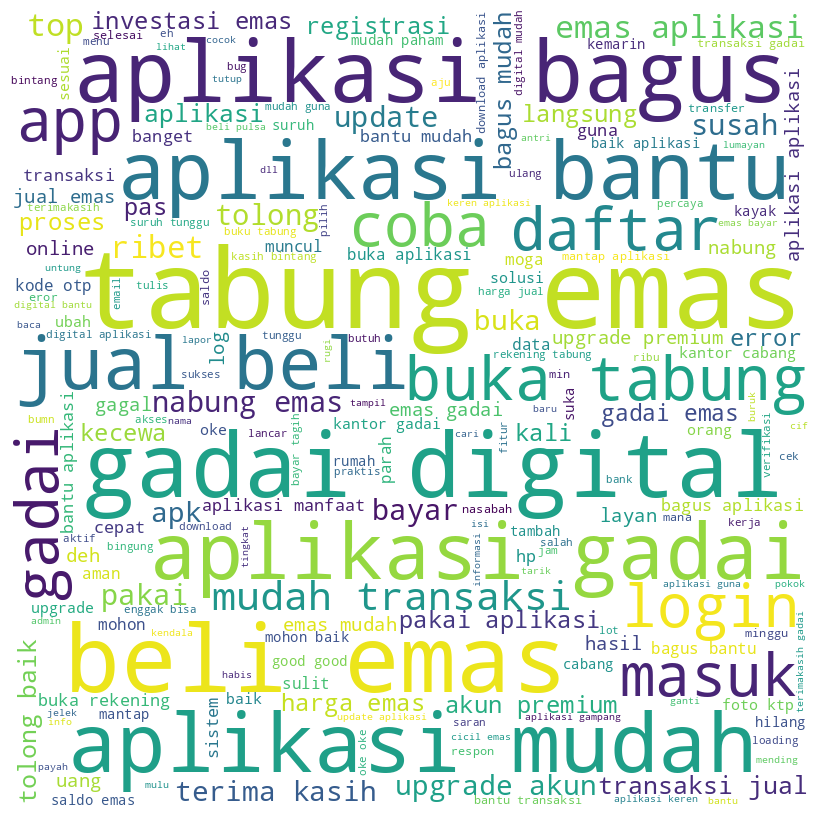

In [ ]:
#create word cloud
content = [str(x).split() for x in stemming_df]
comment_words = ''

for val in content:
  for i in range(len(val)):
    val[i] = val[i].lower()
  
  comment_words += " ".join(val)+" "

wordcloud = WordCloud(width = 800, height = 800, background_color='white',
                      min_font_size = 10).generate(comment_words)

#plot the wordcloud image
plt.figure(figsize = (8, 8), facecolor= None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# CREATE BAG OF WORD

In [ ]:
# def remove_whitespace_LT(text):
#     return text.strip()

# clean_text = tester.apply(remove_whitespace_LT)

def _reduce_exaggerations(text):
    """
    Auxiliary function to help with exxagerated words.
    Examples:
        woooooords -> words
        yaaaaaaaaaaaaaaay -> yay
    """
    correction = str(text)
    #TODO work on complexity reduction.
    return re.sub(r'([\w])\1+', r'\1', correction)

clean_text = tester.apply(lambda x: _reduce_exaggerations(x))


In [ ]:
#Bag Of Word
#membuat numpy array pada list
np.set_printoptions(threshold=sys.maxsize)
np_array = np.array(data['Stemming'])  

In [ ]:
np_array[0:100]

array(['akun buka', 'parahhhh',
       'riwayat no kontrak bos tibatiba hilang notifikasi oppss sila coba aplikasi kemarin error geblek',
       'kasih bintang upgrade premium status tunggu minggu pengajuandaftar bilang aplikasi layak go live',
       'keluh bayar login inisiatif komplain instagram gadai alhamdulillah adminnya responsif langsung login sayang apk eror moga canggih mudah customer',
       'upgrde premium berharihari kerja tim neih woy kagak becus',
       'aplikasi jelek pantesan penggadean lakumenyesal buka rekening penggadean',
       'aplikasi upgrade akun premium minggu ubah', 'apk gunagajelas',
       'update data hilang suruh buku tabung parah',
       'parah kagak login sinyal bagus loading semenjak pers buka aplikasi erorrr',
       'erorrr aplikasi buka atas jam malam deh wasalam aplikasi mohon ada notifikaai ingat bayar cicil kresida telat bayar',
       'erorrr aplikasi buka atas jam malam deh wasalam aplikasi mohon ada notifikaai ingat bayar cicil kresida tel

In [ ]:
#create bag of word feature matrix
count = CountVectorizer()
result_array = count.fit_transform(np_array)

#show feature matrix
bow = result_array.toarray()
bow[0:10]

In [ ]:
#get feature name
feature_names = count.get_feature_names()
feature_names[0:10]

In [ ]:
pd.set_option('display.max_columns', None)
result_bow = pd.DataFrame(bow, columns = feature_names)

In [ ]:
result_bow

In [ ]:
#penerapan tf-idf pada scikit-learn
doc_word = [str(x) for x in clean_text]

vectorizer = TfidfVectorizer()
response = vectorizer.fit_transform(doc_word)
term = vectorizer.get_feature_names()

result_df = pd.DataFrame(response.toarray(), columns = term)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
result

[('akun', 0.21793177094048324)]

In [ ]:
pd.set_option('display.max_columns', None, 'display.max_rows', None)
result_df

In [ ]:
dataset = []
for col, term in enumerate(term):
  dataset.append((term, response.toarray()[0][col]))

In [ ]:
my_list = list(dataset)
decimal = 0.0
result = list()

for row in range(len(my_list)):
  sentence = my_list[row]
  b = decimal in sentence
  if b == False:
    result.append(sentence)
    break

In [ ]:
9#pencarian text
clean_text[clean_text.str.contains(r'(?:\s|^)sampaisampai(?:\s|$)')]